# Numerical feature engineering


## Purpose of this notebook

We want to check if we can add some transformations to numerical features based on domain knowledge to improve the performance of our models.

We will try to discretized some features and also check if certain ones are above/below a normal value for the particular feature (e.g. if bilirubin is above 1.2, it is considered high).

In [15]:
# essentials
import os
import pathlib
from copy import copy


import pandas as pd
import numpy as np
from tqdm import tqdm

# visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MaxAbsScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, make_union, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SequentialFeatureSelector, RFECV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone as clone_model
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

from sklearn.preprocessing import Binarizer, Normalizer, RobustScaler, StandardScaler
from tpot.builtins import StackingEstimator, ZeroCount
from tpot.export_utils import set_param_recursive
from sklearn.preprocessing import FunctionTransformer

# others
import xgboost as xgb 
import lightgbm as lgb
import catboost as cb

RANDOM_SEED = 64

In [16]:
IN_KAGGLE = False
kaggle_folder = "/kaggle/input/"
local_folder = "./data/"
train_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder + "playground-series-s3e26/train.csv", index_col="id")
test_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder  + "playground-series-s3e26/test.csv", index_col="id")
original_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder  + "cirrhosis-prediction-dataset/cirrhosis.csv", index_col="ID")

original_df['generated'] = False
train_df['generated'] = True
test_df['generated'] = False
train_df = pd.concat([train_df, original_df], axis=0)

target_column = "Status"

target_map = {"C": "censored", "CL": "censored due to liver transplant", "D": "death"} # for readability of charts
train_df[target_column] = train_df[target_column].map(target_map)

categorical_features = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
numerical_features = ["N_Days", "Age", "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

We will start with baseline model taking in the raw features, transform the features and compare if there is any improvement in the same models performance.

In [17]:
def base_feature_engineering(df):
    
    df['Drug'] = df['Drug'].map({"D-penicillamine": 1,"Placebo": 0})
    df['Sex'] = df['Sex'].map({"F": 1,"M": 0})

    df["Stage"] = df["Stage"].apply(lambda x: str(x))
    return df


train_df_0 = base_feature_engineering(train_df)

X = train_df_0.drop(columns=target_column)
y = train_df_0[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=RANDOM_SEED, stratify=y, shuffle=True)

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

numeric_transformer = Pipeline(
    [
        ("num_imputer", KNNImputer()),
        ("power_transformer", PowerTransformer()),
    ]
)

categorical_transformer = Pipeline(
    [
        ("cast as str", FunctionTransformer(lambda x: x.astype(str), validate=False)),
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

impute_preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy='median'), numerical_features),
        ("cat", SimpleImputer(strategy="constant", fill_value="MISSING"), categorical_features),
    ]
)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)



models = {
    "default lightgbm": lgb.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=4),
    "xgb": xgb.XGBClassifier(
                objective="multi:softprob", random_state=RANDOM_SEED, n_jobs=-1,
                subsample=0.8,
                min_child_weight=7,
                max_depth=7,
                reg_lambda=0.9,
                gamma=0.9,
                eta=0.08,
                colsample_bytree=0.5,
                reg_alpha=0.5,
                verbosity=0
            ),
    "catboost": cb.CatBoostClassifier(random_state=RANDOM_SEED, verbose=False),
    "GradientBoostingClassifier": GradientBoostingClassifier(
        learning_rate=0.1, 
        max_depth=4, 
        max_features=0.15, 
        min_samples_leaf=4, 
        min_samples_split=5, 
        n_estimators=100, 
        subsample=0.95)
}

data = []
for model_name, model in models.items():
    model_name = "baseline fe - " + model_name
    print(f"Training {model_name}")
    clf = Pipeline(
        [   
            ("preprocessor", preprocessor),
            ("classifier", model),
        ]
    )

    cc_cv = CalibratedClassifierCV(clf, cv=skf)

    cc_cv.fit(X_train, y_train)
    y_pred_proba = cc_cv.predict_proba(X_val)
    y_pred = cc_cv.predict(X_val)
    
    cr = classification_report(y_val, y_pred, output_dict=True)
    print(cr)

    recall_class_0 = confusion_matrix(y_val, y_pred, normalize="true")[0, 0]
    recall_class_1 = confusion_matrix(y_val, y_pred, normalize="true")[1, 1]
    recall_class_2 = confusion_matrix(y_val, y_pred, normalize="true")[2, 2]
    data.append({
        "model": model_name, 
        "log_loss_score": log_loss(y_val, y_pred_proba),
        "avg_precision": cr["macro avg"]["precision"],
        "f1_score": cr["macro avg"]["f1-score"],
        "recall_class_0": recall_class_0,
        "recall_class_1": recall_class_1,
        "recall_class_2": recall_class_2,
    })    

pd.DataFrame(data).drop_duplicates().sort_values(by=["log_loss_score", "recall_class_1"], ascending=[True, False])

Training baseline fe - default lightgbm
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1987
[LightGBM] [Info] Number of data points in the train set: 4993, number of used features: 31
[LightGBM] [Info] Start training from score -0.470845
[LightGBM] [Info] Start training from score -3.322835
[LightGBM] [Info] Start training from score -1.080354
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1985
[LightGBM] [Info] Number of data points in the train set: 4993, number of used features: 31
[LightGBM] [Info] Start training from score -0.470845
[LightGBM] [Info] Start training from score -3.322835
[LightGBM] [Info] Start training from score -1.080

/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1988
[LightGBM] [Info] Number of data points in the train set: 4994, number of used features: 31
[LightGBM] [Info] Start training from score -0.471045
[LightGBM] [Info] Start training from score -3.323036
[LightGBM] [Info] Start training from score -1.079965


/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


{'0': {'precision': 0.8639575971731449, 'recall': 0.9403846153846154, 'f1-score': 0.9005524861878452, 'support': 520.0}, '1': {'precision': 0.75, 'recall': 0.3, 'f1-score': 0.4285714285714285, 'support': 30.0}, '2': {'precision': 0.8431372549019608, 'recall': 0.7597173144876325, 'f1-score': 0.7992565055762082, 'support': 283.0}, 'accuracy': 0.8559423769507803, 'macro avg': {'precision': 0.8190316173583686, 'recall': 0.6667006432907493, 'f1-score': 0.7094601401118273, 'support': 833.0}, 'weighted avg': {'precision': 0.852780064426519, 'recall': 0.8559423769507803, 'f1-score': 0.8491404882987866, 'support': 833.0}}
Training baseline fe - xgb


/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


{'0': {'precision': 0.8652482269503546, 'recall': 0.9384615384615385, 'f1-score': 0.900369003690037, 'support': 520.0}, '1': {'precision': 0.6666666666666666, 'recall': 0.26666666666666666, 'f1-score': 0.3809523809523809, 'support': 30.0}, '2': {'precision': 0.8326848249027238, 'recall': 0.7561837455830389, 'f1-score': 0.7925925925925926, 'support': 283.0}, 'accuracy': 0.8523409363745498, 'macro avg': {'precision': 0.7881999061732484, 'recall': 0.6537706502370814, 'f1-score': 0.6913046590783368, 'support': 833.0}, 'weighted avg': {'precision': 0.8470334735434037, 'recall': 0.8523409363745498, 'f1-score': 0.845047007264219, 'support': 833.0}}
Training baseline fe - catboost


/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


{'0': {'precision': 0.8694096601073346, 'recall': 0.9346153846153846, 'f1-score': 0.9008341056533828, 'support': 520.0}, '1': {'precision': 0.6923076923076923, 'recall': 0.3, 'f1-score': 0.41860465116279066, 'support': 30.0}, '2': {'precision': 0.8275862068965517, 'recall': 0.7632508833922261, 'f1-score': 0.7941176470588235, 'support': 283.0}, 'accuracy': 0.8535414165666266, 'macro avg': {'precision': 0.7964345197705262, 'recall': 0.6659554226692036, 'f1-score': 0.7045188012916657, 'support': 833.0}, 'weighted avg': {'precision': 0.848822509696001, 'recall': 0.8535414165666266, 'f1-score': 0.84721148690551, 'support': 833.0}}
Training baseline fe - GradientBoostingClassifier


/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


{'0': {'precision': 0.8546409807355516, 'recall': 0.9384615384615385, 'f1-score': 0.8945921173235564, 'support': 520.0}, '1': {'precision': 0.8333333333333334, 'recall': 0.16666666666666666, 'f1-score': 0.2777777777777778, 'support': 30.0}, '2': {'precision': 0.82421875, 'recall': 0.7455830388692579, 'f1-score': 0.7829313543599258, 'support': 283.0}, 'accuracy': 0.8451380552220888, 'macro avg': {'precision': 0.8373976880229618, 'recall': 0.6169037479991544, 'f1-score': 0.6517670831537533, 'support': 833.0}, 'weighted avg': {'precision': 0.8435380747088679, 'recall': 0.8451380552220888, 'f1-score': 0.8344427462490295, 'support': 833.0}}


/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,model,log_loss_score,avg_precision,f1_score,recall_class_0,recall_class_1,recall_class_2
1,baseline fe - xgb,0.398958,0.788200,0.691305,0.938462,0.266667,0.756184
3,baseline fe - GradientBoostingClassifier,0.408326,0.837398,0.651767,0.938462,0.166667,0.745583
0,baseline fe - default lightgbm,0.414809,0.819032,0.709460,0.940385,0.300000,0.759717
2,baseline fe - catboost,0.416477,0.796435,0.704519,0.934615,0.300000,0.763251


In [18]:
pd.DataFrame(data).drop_duplicates().sort_values(by=["log_loss_score", "recall_class_1"], ascending=[True, False])

,model,log_loss_score,avg_precision,f1_score,recall_class_0,recall_class_1,recall_class_2
1,baseline fe - xgb,0.398958,0.788200,0.691305,0.938462,0.266667,0.756184
3,baseline fe - GradientBoostingClassifier,0.408326,0.837398,0.651767,0.938462,0.166667,0.745583
0,baseline fe - default lightgbm,0.414809,0.819032,0.709460,0.940385,0.300000,0.759717
2,baseline fe - catboost,0.416477,0.796435,0.704519,0.934615,0.300000,0.763251


## Resulting feature engineering

In [19]:
def num_features_1(df):
    df['bilirubin_increased_levels'] = df['Bilirubin'] > 1.1
    df['cholesterol_increased'] = df['Cholesterol'] > 240
    df["albumin_low"] = df['Albumin'] < 3.5
    df["urinary_copper_increased"] = df['Copper'] > 40
    df["Alk_Phos_increased"] = df['Alk_Phos'] > 1400
    df['SGOT_increased'] = df["SGOT"] > 80 
    df["Tryglicerides_normal"] = df['Tryglicerides'] < 150 
    df["Platelets_normal"] = (df['Platelets'] >= 150) & (df['Platelets'] <= 400)

    new_cat_feature_names = []
    new_num_feature_names = [
        'bilirubin_increased_levels',
        'cholesterol_increased',
        'albumin_low',
        'urinary_copper_increased',
        'Alk_Phos_increased',
        'SGOT_increased',
        'Tryglicerides_normal',
        'Platelets_normal',
    ]
    return df, new_cat_feature_names, new_num_feature_names

def num_features_2(df):
    normal_ranges = {
        'Bilirubin': (0.1, 1.2),
        'Cholesterol': (0, 200),
        'Albumin': (3.5, 5.5),
        'Copper': (10, 30),
        'Alk_Phos': (40, 129),
        'SGOT': (8, 45),
        'Tryglicerides': (48.68, 168.15),
        'Platelets': (150, 400),
        'Prothrombin': (9.4, 12.5)
    }
    df_adding_features = df.copy()

    for feature, (normal_range_min, normal_range_max) in normal_ranges.items():
        df_adding_features[f'{feature}_is_normal'] = (df_adding_features[feature] >= normal_range_min) & (df_adding_features[feature] <= normal_range_max)
        df_adding_features.loc[~df_adding_features[f'{feature}_is_normal'], f'{feature}_deviation'] = abs(df_adding_features[feature] - ((normal_range_min + normal_range_max) / 2))

    df_adding_features.fillna(0, inplace=True)
    
    new_cat_feature_names = [f'{feature}_is_normal' for feature in normal_ranges.keys() ]
    new_num_feature_names = [f'{feature}_deviation' for feature in normal_ranges.keys()]
    
    return df_adding_features, new_cat_feature_names, new_num_feature_names



def num_features_3(df):
    ##initial pass as creating features for meaningful cutoffs
    df['APRI']=100 * (df['SGOT'])/df['Platelets']
    df['under769days']=np.where(df['N_Days']<769, 1, 0)
    df['bilirubin_1.2']=np.where(df['Bilirubin']>1.2, 1, 0)
    df['albumin_low']=np.where(df['Albumin']<2.23, 1, 0)
    df['copper_high']=np.where(df['Copper']>73, 1, 0)
    df['SGOT_high']=np.where(df['SGOT']>73, 1, 0)
    df['Prothrombin_high']=np.where(df['Prothrombin']>10.8, 1, 0)
    df['Edema_yn']=np.where(df['Edema']=='N', 0, 1)
    df['bilirubin_3']=np.where(df['Bilirubin']>3, 1, 0)
    df['high_cholesteroal']=np.where(df['Cholesterol']>240, 1, 0)
    df['age_over_70']=np.where((df['Age']/365)>=70, 1, 0)
    df['abnormal_alp']=np.where(((df['Alk_Phos']<30 )| (df['Alk_Phos']>147)), 1, 0)
    df['very_high_tri']=np.where(df['Tryglicerides']>500, 1, 0)
    df['high_tri']=np.where(df['Tryglicerides']>200, 1, 0)
    df['copper_deficient']=np.where(((df['Sex']=='F') & (df['Copper']<80) |(df['Sex']=='M') & (df['Copper']<70)), 1, 0)
    df['FIB4']=(df['Age']/365)* (df['SGOT']/df['Platelets'])
    df['ALBI']=.66*np.log(df['Bilirubin'])-.085 * df['Albumin']

    new_cat_feature_names = [
        "under769days",
        "bilirubin_1.2",
        "albumin_low",
        "copper_high",
        "SGOT_high",
        "Prothrombin_high",
        "Edema_yn",
        "bilirubin_3",
        "high_cholesteroal",
        "age_over_70",
        "abnormal_alp",
        "very_high_tri",
        "high_tri",
        "copper_deficient",
    ]
    new_num_feature_names = [
        "APRI",
        "FIB4",
        "ALBI",
    ]

    return df, new_cat_feature_names, new_num_feature_names

feature_engineering = {
    "num_features_1": num_features_1, 
    "num_features_2" : num_features_2, 
    "num_features_3": num_features_3
}

In [28]:
numeric_transformers = [
                ("PowerTransformer", sklearn.preprocessing.PowerTransformer()),
                ("QuantileTransformer", sklearn.preprocessing.QuantileTransformer()),
            ]

for with_generated_data in ["yes", "merge"]:
    for f_eng_name, f_eng_fun in feature_engineering.items():
        for model_name, model in models.items():
            train_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder + "playground-series-s3e26/train.csv", index_col="id")

            categorical_features = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
            numerical_features = ["N_Days", "Age", "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

            if with_generated_data == "yes":
                original_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder  + "cirrhosis-prediction-dataset/cirrhosis.csv", index_col="ID")
                original_df['generated'] = False
                train_df['generated'] = True
                train_df = pd.concat([train_df, original_df], axis=0)
                train_df = train_df.reset_index(drop=True)
                categorical_features += ["generated"]
            elif with_generated_data == "merge":
                original_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder  + "cirrhosis-prediction-dataset/cirrhosis.csv", index_col="ID")
                train_df = pd.concat([train_df, original_df], axis=0)
                train_df = train_df.reset_index(drop=True)

            
            iter_model_name = f"{model_name} - {f_eng_name}, generated data: {with_generated_data}"
            train_df, new_cat, new_num = f_eng_fun(train_df)
            train_df = base_feature_engineering(train_df)


            categorical_features += new_cat
            numerical_features += new_num

            X = train_df.drop(columns=target_column)
            y = train_df[target_column]

            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, shuffle=True)

            le = LabelEncoder()

            y_train = le.fit_transform(y_train)
            y_val = le.transform(y_val)
            
            model = clone_model(model)

            clf = Pipeline(
                [   
                    ("preprocessor", preprocessor),
                    ("classifier", model),
                ]
            )
            
            cc_cv = CalibratedClassifierCV(clf, cv=skf)

            cc_cv.fit(X_train, y_train)
            y_pred_proba = cc_cv.predict_proba(X_val)
            y_pred = cc_cv.predict(X_val)
            
            cr = classification_report(y_val, y_pred, output_dict=True)

            recall_class_0 = confusion_matrix(y_val, y_pred, normalize="true")[0, 0]
            recall_class_1 = confusion_matrix(y_val, y_pred, normalize="true")[1, 1]
            recall_class_2 = confusion_matrix(y_val, y_pred, normalize="true")[2, 2]
            data.append({
                "model": iter_model_name, 
                "model_family": model_name,
                "feature_engineering": f_eng_name,
                "with_generated_data": with_generated_data,
                "log_loss_score": log_loss(y_val, y_pred_proba),
                "avg_precision": cr["macro avg"]["precision"],
                "f1_score": cr["macro avg"]["f1-score"],
                "recall_class_0": recall_class_0,
                "recall_class_1": recall_class_1,
                "recall_class_2": recall_class_2,
            })    

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1983
[LightGBM] [Info] Number of data points in the train set: 4993, number of used features: 31
[LightGBM] [Info] Start training from score -0.470845
[LightGBM] [Info] Start training from score -3.322835
[LightGBM] [Info] Start training from score -1.080354
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1980
[LightGBM] [Info] Number of data points in the train set: 4993, number of used features: 31
[LightGBM] [Info] Start training from score -0.470845
[LightGBM] [Info] Start training from score -3.322835
[LightGBM] [Info] Start tr

In [29]:
pd.set_option('display.max_colwidth', 170)
pd.DataFrame(data).drop_duplicates().sort_values(by=["log_loss_score"], ascending=True)

,model,log_loss_score,avg_precision,f1_score,recall_class_0,recall_class_1,recall_class_2
1,baseline fe - xgb,0.398958,0.788200,0.691305,0.938462,0.266667,0.756184
3,baseline fe - GradientBoostingClassifier,0.408326,0.837398,0.651767,0.938462,0.166667,0.745583
41,"xgb - num_features_1, generated data: merge",0.411505,0.751297,0.651001,0.930769,0.166667,0.770318
0,baseline fe - default lightgbm,0.414809,0.819032,0.709460,0.940385,0.300000,0.759717
2,baseline fe - catboost,0.416477,0.796435,0.704519,0.934615,0.300000,0.763251
45,"xgb - num_features_2, generated data: merge",0.420456,0.818548,0.672806,0.936538,0.200000,0.770318
49,"xgb - num_features_3, generated data: merge",0.422235,0.751190,0.651000,0.934615,0.166667,0.766784
36,"default lightgbm - num_features_3, generated data: yes",0.426892,0.836000,0.654348,0.925000,0.166667,0.773852
33,"xgb - num_features_2, generated data: yes",0.435836,0.759258,0.639580,0.932692,0.133333,0.773852
51,"GradientBoostingClassifier - num_features_3, generated data: merge",0.435969,0.733077,0.607393,0.930769,0.066667,0.784452


<Axes: xlabel='log_loss_score', ylabel='feature engineering fun'>

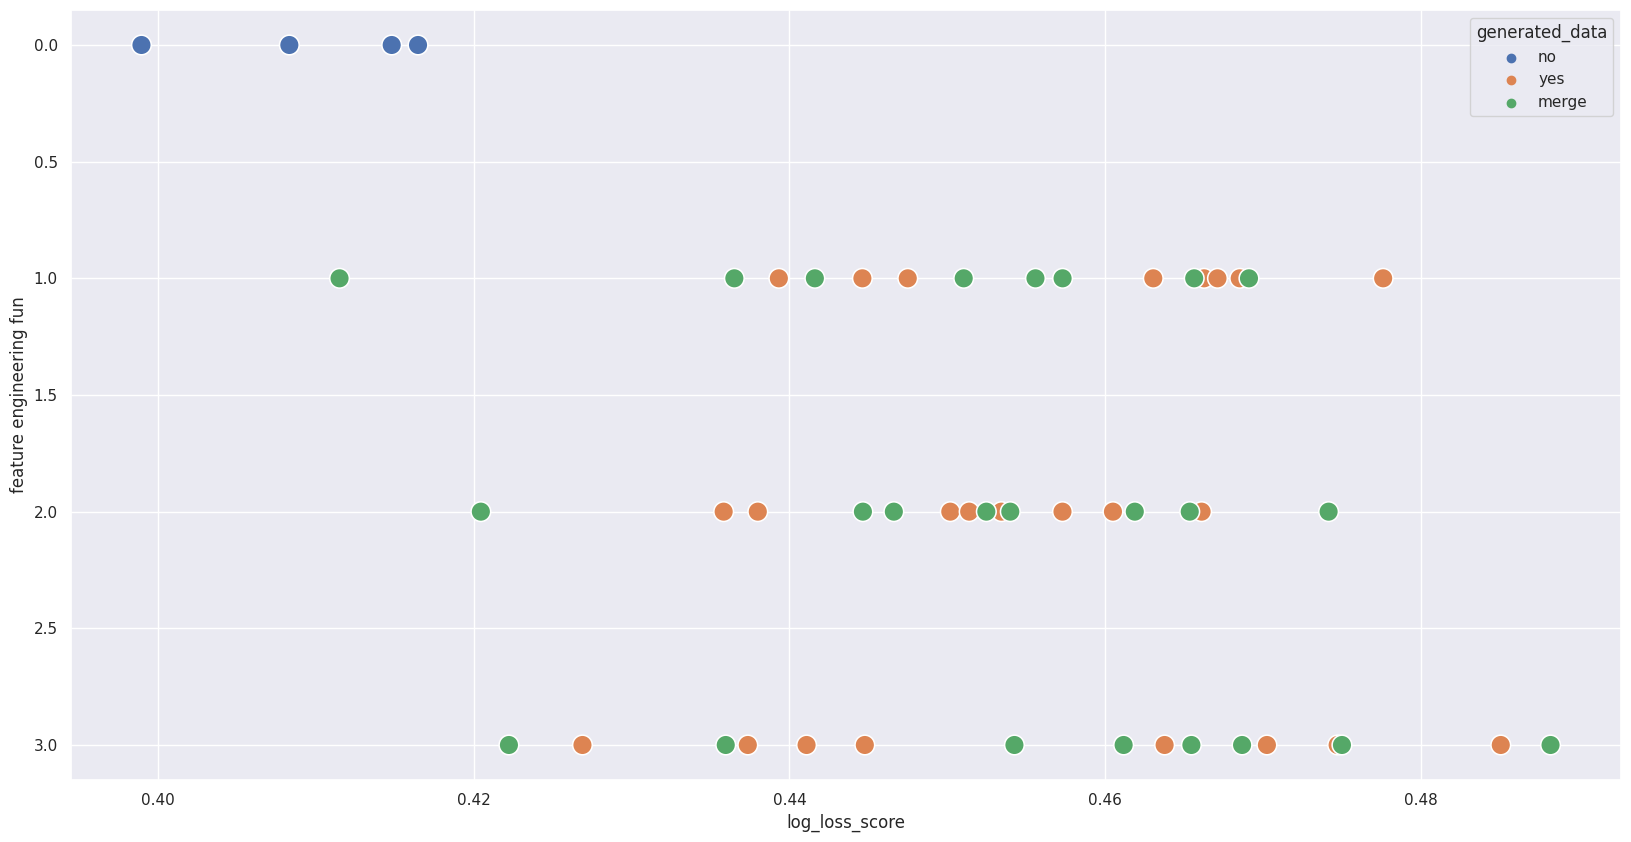

In [30]:
result_df = pd.DataFrame(data).drop_duplicates()

result_df['generated_data'] = result_df['model'].apply(lambda x: x.split("generated data: ")[1] if "generated data: " in x else "no")
# get the number from the model name
result_df['feature engineering fun'] = result_df['model'].apply(lambda x: x.replace("num_features_",",").split(",")[1] if "num_features_" in x else 0)
result_df

# set shape
sns.set(rc={'figure.figsize':(20,10)})
sns.scatterplot(data=result_df, x="log_loss_score", y="feature engineering fun", hue="generated_data", s=200)